# Pets Expression Classification

In [1]:
from google.colab import files
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torchvision.transforms.functional import to_pil_image

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


**Dataset Preparation**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [4]:
data_path=path+"/Master Folder"

Validation and Test Transformations

In [5]:
val_test_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=True), # resizing to the standard input size
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Training Transformation

In [6]:
train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Augmentation
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

Dataset Loading

In [7]:
train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=f"{data_path}/valid", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_path}/test",  transform=val_test_transforms)

Create Dataloaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [9]:
len(train_loader), len(valid_loader), len(test_loader)

(32, 2, 2)

In [10]:
print("Class labels:", train_dataset.classes)

Class labels: ['Angry', 'Other', 'Sad', 'happy']


In [11]:
images, labels = next(iter(test_loader))
print(images.shape)
print(images[0].shape)
print(labels)


torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3])


In [12]:
np.max(np.array(images[0]))

np.float32(0.96862745)

In [13]:
class_names=train_dataset.classes

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def train(lrs,epochs,train_loader,valid_loader,model_name,device):
  loss_function = nn.CrossEntropyLoss()
  losses=[]
  models=[]
  accuracies=[]
  best_epoch=0
  best_lr=0
  best_accuracy=0
  best_model=None
  #print(lrs,epochs)
  for lr in lrs:
    #print("ana hena")
    for epoch in epochs:
        #print(lrs,epochs)
        print(f"Training with Learning Rate = {lr} and Epochs = {epoch}")
        if model_name =="vgg":
          model = VGG16().to(device)
        elif model_name=="resnet":
          model = ResNet(block,[3,4,6,3],4).to(device)
        else :
          model=InceptionV3().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        run_loss = []

        for e in range(epoch):
            training_loss = 0.0
            for i, data in enumerate(train_loader):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()  # Reset the grads
                outputs = model(images)  # Forward pass
                loss = loss_function(outputs, labels)
                training_loss += loss.item()
                loss.backward()  # Backpropagation
                optimizer.step()
                run_loss.append(loss.item())

            if (e + 1) % 10 == 0:
                print(f"Epoch = {e+1}/{epoch} | Learning Rate = {lr} | Loss = {training_loss/len(train_loader):.4f}")

                # --- Save checkpoint every 10 epochs ---
                # checkpoint_path = f"checkpoints/{model_name}_lr{lr}_epoch{e+1}.pt"
                # torch.save({
                #     'epoch': e + 1,
                #     'model_state_dict': model.state_dict(),
                #     'optimizer_state_dict': optimizer.state_dict(),
                #     'loss': training_loss,
                # }, checkpoint_path)
                # print(f"Checkpoint saved: {checkpoint_path}")

        losses.append(run_loss)
        #models.append(model)

        # Evaluate each network on the Validation set
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f"Validation Accuracy = {accuracy:.2f}%")

        model.train()  # Return model to training mode
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lr = lr
            best_epoch = epoch
            best_model_state = model.state_dict()
            best_model=model
        #print(lrs,epochs)


  return best_model,losses,accuracies



In [16]:
def plot_loss(loss,length,accuracies):
# Convert batch-level loss into epoch-level average loss
  epoch_losses = [
      sum(loss[i * length : (i + 1) * length]) / length
      for i in range(len(loss) // length)
  ]
  plt.figure(figsize=(10, 5))
  plt.plot(range(len(epoch_losses)), epoch_losses, label='Training Loss')
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title(f"Training Loss for Best Model (Accuracy: {accuracies[best_index]:.2f}%)")
  plt.legend()
  plt.grid(True)
  plt.show()




In [17]:
def test(model,test_loader,device):
  preds=[]
  new_labels=[]
  with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        new_labels.extend(labels.cpu().numpy())
    return new_labels,preds


In [18]:
def metrics(model,labels,preds):
  acc = accuracy_score(labels, preds)

  # Precision, Recall, F1-score
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  f1 = f1_score(labels, preds, average='macro')

  # Confusion Matrix
  cm = confusion_matrix(labels, preds)

  # Full classification report
  report = classification_report(labels, preds)

  # Print
  print(f"Accuracy: {acc:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")
  print("\nConfusion Matrix:")
  print(cm)
  print("\nClassification Report:\n", report)


In [19]:
def test_images(test_dataset,class_names,preds):
  random_index=np.random.randint(0, len(test_dataset))
  image, label = test_dataset[random_index]
  inv_normalize = v2.Normalize(
      mean=[-1, -1, -1],
      std=[2, 2, 2]
  )
  image_display = inv_normalize(image).clamp(0, 1)
  actual_label=class_names[label]
  predicted_class=preds[random_index]
  predicted_label=class_names[predicted_class]
  # Plot
  plt.imshow(to_pil_image(image_display))
  plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
  plt.axis('off')
  plt.show()


# Networks

Visual Geometry Group (VGG-16)

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*B_ZaaaBg2njhp8SThjCufA.png)

In [20]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()

        self.features=nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        #Fully Connected Layers
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

    def forward(self, x):
        x=self.features(x)
        x=self.classifier(x)
        return x




Training VGG

In [21]:
lrs=[0.00001,0.0001]
epochs=[40,50]
vgg_loss=[]
models=[]
accuracies=[]
best_epoch=0
best_lr=0
best_accuracy=0
os.makedirs("checkpoints", exist_ok=True)

Best Model

In [22]:
best_vgg_model,vgg_loss,vgg_accuracies=train(lrs,epochs,train_loader,valid_loader,'vgg',device)

Training with Learning Rate = 1e-05 and Epochs = 40
Epoch = 10/40 | Learning Rate = 1e-05 | Loss = 1.3864
Epoch = 20/40 | Learning Rate = 1e-05 | Loss = 1.3867
Epoch = 30/40 | Learning Rate = 1e-05 | Loss = 1.3864
Epoch = 40/40 | Learning Rate = 1e-05 | Loss = 1.3865
Validation Accuracy = 16.67%
Training with Learning Rate = 1e-05 and Epochs = 50
Epoch = 10/50 | Learning Rate = 1e-05 | Loss = 1.3863
Epoch = 20/50 | Learning Rate = 1e-05 | Loss = 1.3864
Epoch = 30/50 | Learning Rate = 1e-05 | Loss = 1.3865
Epoch = 40/50 | Learning Rate = 1e-05 | Loss = 1.3837
Epoch = 50/50 | Learning Rate = 1e-05 | Loss = 1.3515
Validation Accuracy = 33.33%
Training with Learning Rate = 0.0001 and Epochs = 40
Epoch = 10/40 | Learning Rate = 0.0001 | Loss = 1.3868
Epoch = 20/40 | Learning Rate = 0.0001 | Loss = 1.3868
Epoch = 30/40 | Learning Rate = 0.0001 | Loss = 1.3867
Epoch = 40/40 | Learning Rate = 0.0001 | Loss = 1.3862
Validation Accuracy = 30.56%
Training with Learning Rate = 0.0001 and Epochs = 

In [23]:
best_index=vgg_accuracies.index(max(vgg_accuracies))
best_loss=vgg_loss[best_index]

In [24]:
print(f"Best model at index {best_index} with Accuracy = {vgg_accuracies[best_index]:.2f}%")
torch.save(best_vgg_model.state_dict(), 'best_vgg_model.pth')

Best model at index 1 with Accuracy = 33.33%


Loss

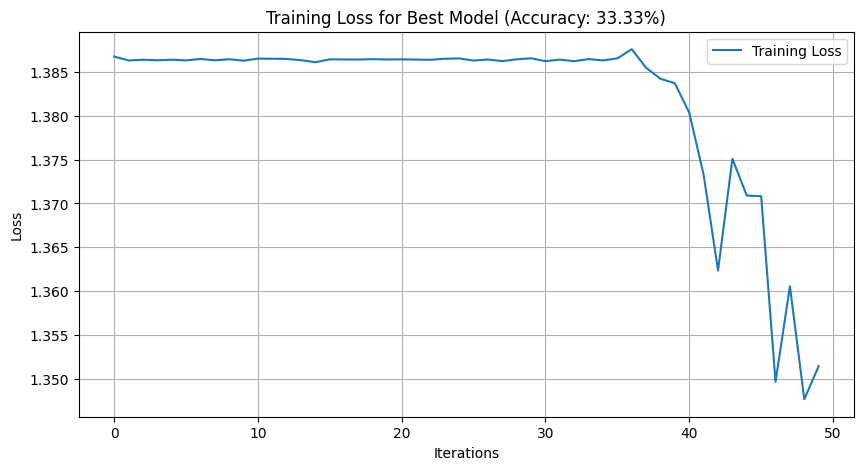

In [25]:
plot_loss(best_loss,len(train_loader),vgg_accuracies)

Evaluating the model

In [26]:
labels,preds=test(best_vgg_model,test_loader,device)

In [27]:
metrics(best_vgg_model,labels,preds)

Accuracy: 0.2105
Precision: 0.2159
Recall: 0.2242
F1-score: 0.2171

Confusion Matrix:
[[2 3 2 3]
 [1 2 1 2]
 [4 1 2 4]
 [4 2 3 2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.20      0.19        10
           1       0.25      0.33      0.29         6
           2       0.25      0.18      0.21        11
           3       0.18      0.18      0.18        11

    accuracy                           0.21        38
   macro avg       0.22      0.22      0.22        38
weighted avg       0.21      0.21      0.21        38



Evaluating the model on the images

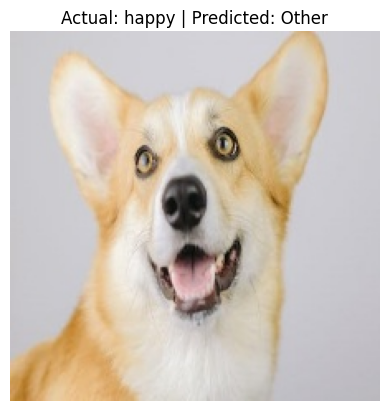

In [28]:
test_images(test_dataset,class_names,preds)

**ResNet**


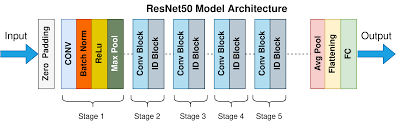

ResNet Bottleneck Block

Instead of stacking the layers, resnet adds a shortcut => F(x) + x

In [29]:
class block(nn.Module):
  def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
    super(block,self).__init__()
    self.expansion=4 #expands the channels
    self.identity_downsample=identity_downsample # downsample the input if input dims!=output dims
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1), #reduce channels
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,3,stride,padding=1), #same size
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels*self.expansion,kernel_size=1,stride=1), #expand
        nn.BatchNorm2d(out_channels*self.expansion)
    )
    self.relu=nn.ReLU(inplace=True)

  def forward(self,x):
    identity=x
    x=self.block(x)

    if self.identity_downsample is not None:
      identity=self.identity_downsample(identity) #match the shape with shortcut

    x+=identity #residual connection
    x=self.relu(x)
    return x



In [30]:
class ResNet(nn.Module):
  def __init__(self, block,layers,num_classes,image_channels=3) :
     super(ResNet,self).__init__()
     self.in_channels=64
     self.conv1=nn.Conv2d(image_channels,64,7,stride=2,padding=3)
     self.bn1=nn.BatchNorm2d(64)
     self.relu=nn.ReLU(inplace=True)
     self.maxpool=nn.MaxPool2d(3,2,1)


     self.layer1=self.make_layer(block,layers[0],out_channels=64,stride=1)
     self.layer2=self.make_layer(block,layers[1],out_channels=128,stride=2)
     self.layer3=self.make_layer(block,layers[2],out_channels=256,stride=2)
     self.layer4=self.make_layer(block,layers[3],out_channels=512,stride=2)

     self.avgpool=nn.AdaptiveAvgPool2d((1,1))
     self.fc=nn.Linear(512*4,num_classes)
  def forward(self,x):
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.maxpool(x)

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)
    x=self.avgpool(x)
    x=torch.flatten(x,1)
    x=self.fc(x)
    return x
  # creates multiple blocks in a layer
  def make_layer(self,block,num_res_blocks,out_channels,stride):
    identity_downsample=None
    layers=[]

    if stride!=1 or self.in_channels!=out_channels*4:
      identity_downsample=nn.Sequential(nn.Conv2d(self.in_channels,out_channels*4,1,stride),
                                        nn.BatchNorm2d(out_channels*4))
    layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
    self.in_channels=out_channels*4

    for i in range(num_res_blocks-1):
      layers.append(block(self.in_channels,out_channels))

    return nn.Sequential(*layers)




In [31]:
resnet_50=ResNet(block,[3,4,6,3],4)
x=torch.randn(2,3,224,224)
y=resnet_50(x)
print(y.shape
      )

torch.Size([2, 4])


In [32]:
lrs=[0.00001,0.0001]
epochs=[40,50]
resnet_loss=[]
models=[]
accuracies=[]
best_epoch=0
best_lr=0
best_accuracy=0

In [ ]:
best_resnet_model,resnet_loss,resnet_accuracies=train(lrs,epochs,train_loader,valid_loader,'resnet',device)

Training with Learning Rate = 1e-05 and Epochs = 40
Epoch = 10/40 | Learning Rate = 1e-05 | Loss = 1.3344
Epoch = 20/40 | Learning Rate = 1e-05 | Loss = 1.2870
Epoch = 30/40 | Learning Rate = 1e-05 | Loss = 1.2241
Epoch = 40/40 | Learning Rate = 1e-05 | Loss = 1.1639
Validation Accuracy = 36.11%
Training with Learning Rate = 1e-05 and Epochs = 50
Epoch = 10/50 | Learning Rate = 1e-05 | Loss = 1.3390
Epoch = 20/50 | Learning Rate = 1e-05 | Loss = 1.2595
Epoch = 30/50 | Learning Rate = 1e-05 | Loss = 1.1970
Epoch = 40/50 | Learning Rate = 1e-05 | Loss = 1.1339
Epoch = 50/50 | Learning Rate = 1e-05 | Loss = 1.0689
Validation Accuracy = 36.11%
Training with Learning Rate = 0.0001 and Epochs = 40
Epoch = 10/40 | Learning Rate = 0.0001 | Loss = 1.3072
Epoch = 20/40 | Learning Rate = 0.0001 | Loss = 1.0761
Epoch = 30/40 | Learning Rate = 0.0001 | Loss = 0.9792
Epoch = 40/40 | Learning Rate = 0.0001 | Loss = 0.7747
Validation Accuracy = 22.22%
Training with Learning Rate = 0.0001 and Epochs = 

In [ ]:
best_index=resnet_accuracies.index(max(resnet_accuracies))
best_loss=resnet_loss[best_index]

In [ ]:
print(f"Best model at index {best_index} with Accuracy = {resnet_accuracies[best_index]:.2f}%")
torch.save(best_resnet_model.state_dict(), 'best_resnet_model.pth')

In [ ]:
labels,preds=test(best_resnet_model,test_loader,device)


In [ ]:
plot_loss(best_loss,len(train_loader),resnet_accuracies)


In [ ]:
metrics(best_resnet_model,labels,preds)


In [ ]:
test_images(test_dataset,class_names,preds)

**Inception V3**

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*uVRWg5TG5_3W18qdhpo3XQ.png)

Stem Block

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*hPGOjojFtkUjKMqae82Oyg.jpeg)





![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*EXFJ5rRi0Pv4DgVUfydPMg.jpeg)

In [ ]:
class conv_block(nn.Module):
    def __init__(self , in_channels , out_channels , kernel_size , stride =1, padding=0):
        super().__init__()
        self.relu=nn.ReLU()
        self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride , padding)
        self.batchnorm=nn.BatchNorm2d(out_channels)
    def forward(self,x):
        return self.relu(self.batchnorm(self.conv(x)))

In [ ]:
class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.block=nn.Sequential(
        conv_block(3,32,3,2,0),
        conv_block(32,32,3,1,0),
        conv_block(32,64,3,1,1),
        nn.MaxPool2d(kernel_size=(3,3) , stride=(2,2)),
        conv_block(64,80,3,1,0),
        conv_block(80,192,3,1,1),
        nn.MaxPool2d(kernel_size=(3,3) , stride=(2,2))

        )

    def forward(self,x):

        return self.block(x)

In [ ]:
class InceptionA(nn.Module):
    def __init__(self,input_channels,output_channels):
        super().__init__()
        self.branch1=nn.Sequential(
            conv_block(input_channels,64,kernel_size=1,stride=1,padding=0),
            conv_block(64,96,kernel_size=3,stride=1,padding=1),
            conv_block(96,96,kernel_size=3,stride=1,padding=1),

        )
        self.branch2=nn.Sequential(
            conv_block(input_channels,48,kernel_size=1),
            conv_block(48,64,kernel_size=3,padding=1),

        )
        self.branch3=nn.Sequential(
            nn.AvgPool2d(kernel_size=3,stride=1,padding=1),
            conv_block(input_channels,64,kernel_size=1),

        )
        self.branch4=nn.Sequential(
            conv_block(input_channels,64,kernel_size=1),

        )

    def forward(self,x):
        output1=self.branch1(x)
        output2=self.branch2(x)
        output3=self.branch3(x)
        output4=self.branch4(x)
        return torch.cat([output1,output2,output3,output4],dim=1)




In [ ]:
class InceptionB(nn.Module):
    def __init__(self,input_channels,output_channels):
        super().__init__()
        self.branch1=nn.Sequential(
            conv_block(input_channels,192,1)
            )

        self.branch2=nn.Sequential(
            conv_block(input_channels,output_channels,1),
            conv_block(output_channels,output_channels,(1,7),padding=(0,3)),
            conv_block(output_channels , 192 , (7,1)  ,padding= (3,0)),

        )
        self.branch3 = nn.Sequential(
        conv_block(input_channels , output_channels , 1 , 1 , 0),
        conv_block(output_channels , output_channels , (7,1) , 1 , (0,3)),
        conv_block(output_channels , output_channels , (1,7) , 1 , (3,0)),
        conv_block(output_channels , output_channels , (7,1) , 1 , (0,3)),
        conv_block(output_channels , 192 , (1,7) , 1 , (3,0)),
    )
        self.branch4 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3,3) , stride=1 , padding=1),
        conv_block(input_channels , 192 , 1 , 1 , 0)
    )

    def forward(self,x):
        output1=self.branch1(x)
        output2=self.branch2(x)
        output3=self.branch3(x)
        output4=self.branch4(x)
        return torch.cat([output1,output2,output3,output4],dim=1)




In [ ]:
class InceptionC(nn.Module):
    def __init__(self,input_channels):
        super().__init__()
        self.branch1=nn.Sequential(
            conv_block(input_channels,448,1),
            conv_block(448,384,3,padding=1),


        )
        self.branch11=conv_block(384,384,kernel_size=(1,3),padding=(0,1))
        self.branch12=conv_block(384,384,kernel_size=(3,1),padding=(1,0))
        self.branch2=conv_block(input_channels,384,1)
        self.branch21=conv_block(384,384,kernel_size=(3,1),padding=(1,0))
        self.branch22=conv_block(384,384,kernel_size=(1,3),padding=(0,1))

        self.branch3=nn.Sequential(
            nn.AvgPool2d(kernel_size=3,stride=1,padding=1),
           conv_block(input_channels,192,1),
        )
        self.branch4=conv_block(input_channels,320,1)

    def forward(self,x):
        output1=self.branch1(x)
        output11=self.branch11(output1)
        output12=self.branch12(output1)
        output2=self.branch2(x)
        output21=self.branch21(output2)
        output22=self.branch22(output2)
        output3=self.branch3(x)
        output4=self.branch4(x)
        return torch.cat([output11,output12,output21,output22,output3,output4],dim=1)




In [ ]:
class ReductionA(nn.Module):
    def __init__(self,input_channels):
        super().__init__()

        self.branch1=nn.Sequential(
            conv_block(input_channels,64,1),
            conv_block(64,96,3,padding=1),
            conv_block(96,96,3,2,0)

        )
        self.branch2=nn.Sequential(
            conv_block(input_channels,384,3,stride=2),
        )
        self.branch3=nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
    def forward(self,x):
        output1=self.branch1(x)
        output2=self.branch2(x)
        output3=self.branch3(x)
        return torch.cat([output1,output2,output3],dim=1)



In [ ]:
class ReductionB(nn.Module):
    def __init__(self,input_channels):
        super().__init__()

        self.branch1 = nn.Sequential(
        conv_block(input_channels , 192 , 1 , 1 , 0),
        conv_block(192 , 192 , (1,7) , 1 , (3,0)),
        conv_block(192 , 192 , (7,1) , 1 , (0,3)),

        conv_block(192 , 192 , 3 , 2, 0),
    )
        self.branch2=nn.Sequential(
            conv_block(input_channels , 192 , 1 , 1 , 0),
            conv_block(192 , 320 , 3 , 2 , 0),
        )
        self.branch3=nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
    def forward(self,x):
        output1=self.branch1(x)
        output2=self.branch2(x)
        output3=self.branch3(x)
        return torch.cat([output1,output2,output3],dim=1)



In [ ]:
class AuxBlock(nn.Module):
    def __init__(self,input_channels):
        super().__init__()
        self.block=nn.Sequential(
            nn.AvgPool2d(kernel_size=5,padding=2,stride=1),
            conv_block(input_channels , 128 , 1 , 1 , 0),
            conv_block(128 , 768 , 5 , 1 , 0),

        )
        self.linear=nn.Sequential(
            nn.Linear(in_features= 49152 , out_features= 1024),
            nn.ReLU(),
            nn.Linear(in_features= 1024 , out_features= 4),
            #nn.Softmax(dim=1)

        )

    def forward(self,x):
            x=self.block(x)
            x=torch.flatten(x,1)
            out=self.linear(x)
            return out





In [ ]:
class InceptionV3(nn.Module):
  def __init__(self):
    super(InceptionV3 , self).__init__()
    #print("ana hena")
    self.block=nn.Sequential(
       Stem(),
       InceptionA(192 , 32),
       InceptionA(288 , 64),
       InceptionA(288 , 64),
       ReductionA(288),
       InceptionB(768 , 128),
       InceptionB(768 , 160),
       InceptionB(768 , 160),
       InceptionB(768 , 192),


    )
    self.aux=nn.Sequential(
        AuxBlock(768),
    )
    self.block2=nn.Sequential(
      ReductionB(768),
      InceptionC(1280),
      InceptionC(2048),
      nn.AdaptiveAvgPool2d((1, 1))
    )

    self.linear=nn.Sequential(
       nn.Linear(in_features=2048 ,out_features= 2048),
       nn.ReLU(),
       nn.Linear(in_features=2048 , out_features= 4),
      # nn.Softmax()
    )

  def forward(self , x):
    out=self.block(x)
    aux=self.aux(out)
    out=self.block2(out)
    out=torch.flatten(out,1)
    out=self.linear(out)
    return out

In [ ]:
inception=InceptionV3()
x=torch.randn(2,3,224,224)
print(inception(x))



In [ ]:
best_inception_model,inception_loss,inception_accuracies=train(lrs,epochs,train_loader,valid_loader,'inception',device)

In [ ]:
best_index=inception_accuracies.index(max(inception_accuracies))
best_loss=inception_loss[best_index]
print(f"Best model at index {best_index} with Accuracy = {inception_accuracies[best_index]:.2f}%")


In [ ]:
torch.save(best_inception_model.state_dict(), 'best_inception_model.pth')
plot_loss(best_loss,len(train_loader),inception_accuracies)

In [ ]:
labels,preds=test(best_inception_model,test_loader,device)

In [ ]:
metrics(best_inception_model,labels,preds)

In [ ]:
test_images(test_dataset,class_names,preds)

In [ ]:
len(vgg_accuracies)